In [1]:
import os
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import roc_curve, auc

<h1>Plot results</h1>

<h3>Globals</h3>

In [2]:
all_indicators = {}

all_indicators["BMF"] = ["BMF_R1", "BMF_R2", "BMF_R3", "BMF_R4", "BMF_R5", "BMF_R6", "BMF_R7"]
all_indicators["CHO"] = ["CHO_R1", "CHO_R2", "CHO_R3", "CHO_R4", "CHO_R5", "CHO_R6", "CHO_R7"]

def get_indicators(location):
    return all_indicators[location]

In [3]:
ewater_values = [0,2750]

In [4]:
model_types = ["combined_ind_intercept", "combined_ind_intercept_lagged", "combined_ind_intercept_inflow_ewater", "combined_interaction"] 

In [5]:
data_dir = "../results"
fig_dir = "../results/figs"

# data_dir = "../data"
# results_dir = "../results"

<h3>Read data</h3>
Save all the data for location and model combinations into a dictionary for easy access<br>
We load (rather than open) the dataset and then close it, to reduce the risk of nc permission errors.

In [7]:
predictions = {}
obs = {}

for location in all_indicators.keys():

    for model_name in model_types:

        
        predictions_dset = xr.load_dataset(os.path.join(data_dir,f'{location}_posterior_predictive_{model_name}_model.nc'))
        obs_dset = xr.load_dataset(os.path.join(data_dir, f'{location}_obs_{model_name}_model.nc'))
        
        obs_dset = obs_dset["__xarray_dataarray_variable__"]
        predictions_dset = predictions_dset["__xarray_dataarray_variable__"]
        
        predictions_dset.close()
        obs_dset.close()

        dset_name = f"{location}-{model_name}"
        predictions[dset_name] = predictions_dset
        obs[dset_name] = obs_dset


<h3>Set location</h3>
Brier skill score is plotted with multiple models per location

In [8]:
location = "CHO"
model_types = ["combined_ind_intercept_inflow_ewater","combined_ind_intercept", "combined_ind_intercept_lagged"]
model_names_for_plotting = ["2Pred-Ind","2Pred-Shared", "3Pred-Shared"]

<h3>Brier skill score</h3>

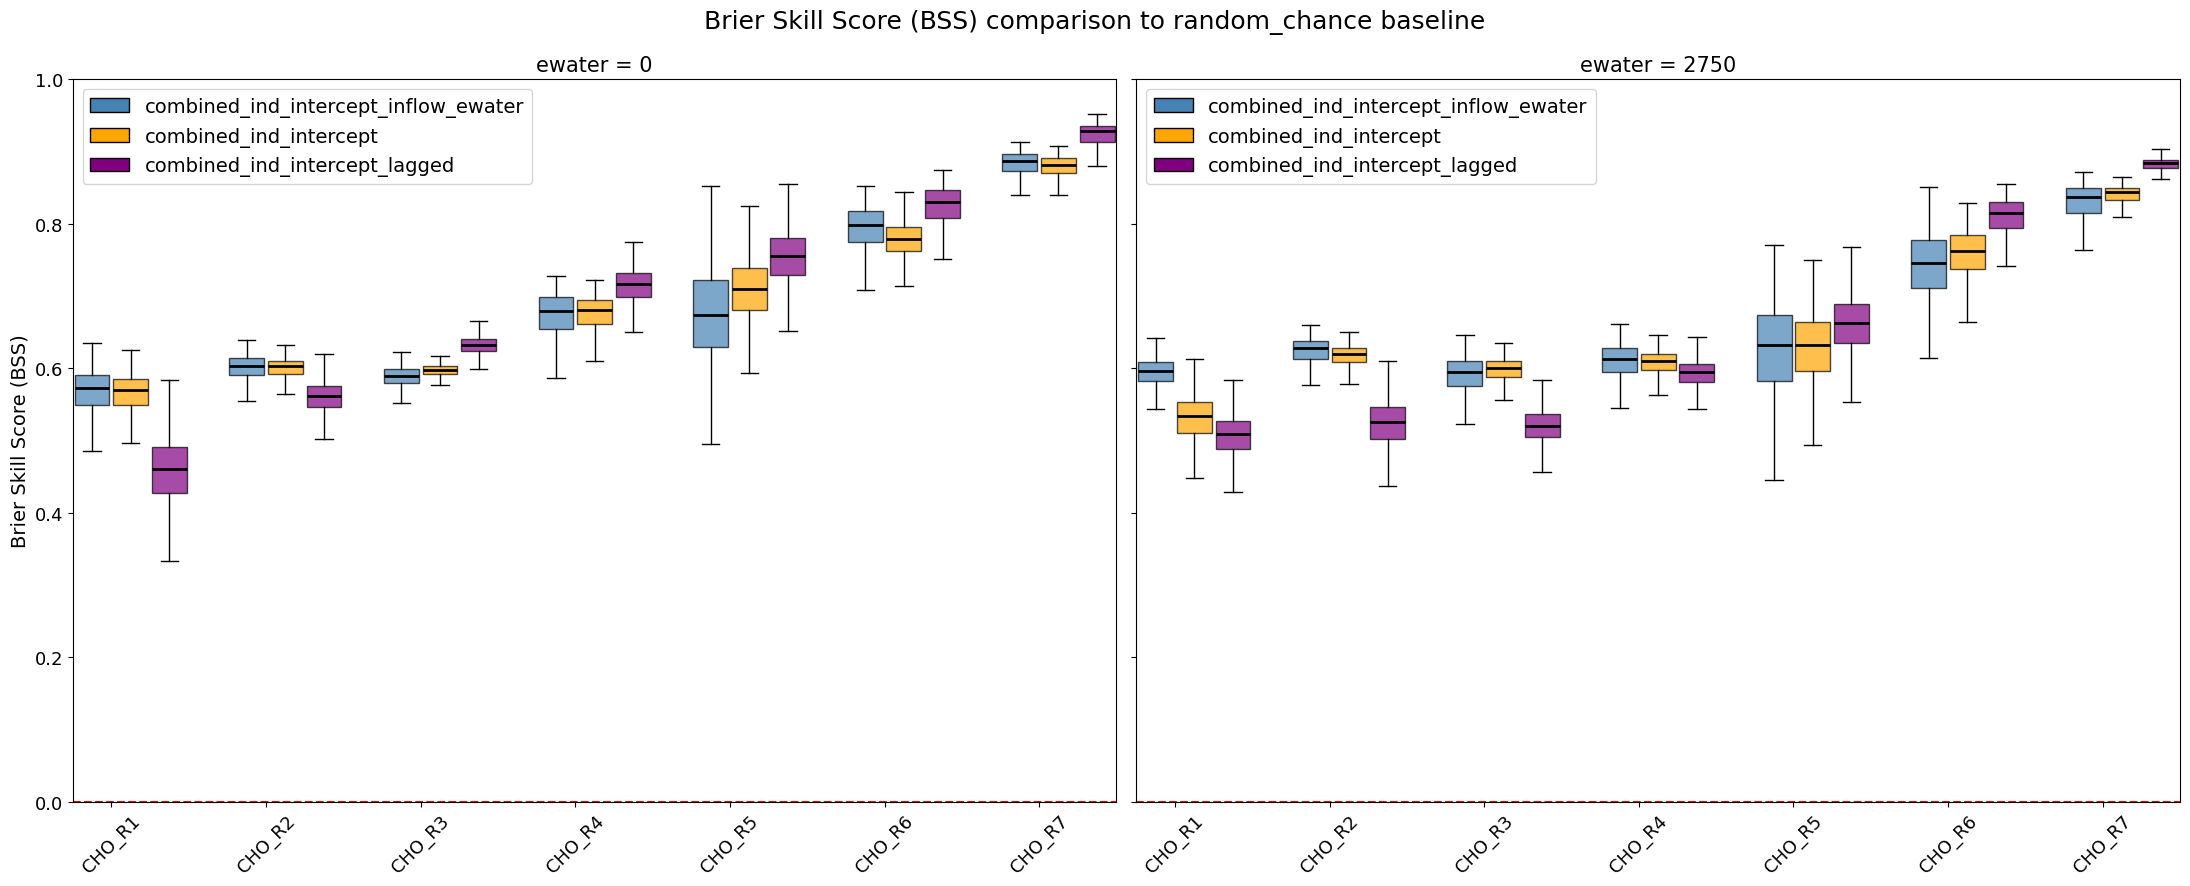

In [10]:


# Choose baseline method: 'climatology', 'random_chance', or 'majority'
baseline = 'random_chance'

# Assuming `indicators` and `ewater_values` are defined
indicators = get_indicators(location)

# Storing results separately for each model
bss_all_scenarios = {0: {}, 2750: {}}  # ewater levels

for threshold_i in range(0, 7):
    
    indicator = indicators[threshold_i]
    
    for ewater in ewater_values:
        for model_name in model_types:
            
            dset_name = f"{location}-{model_name}"  
            
            y = obs[dset_name][ewater_values.index(ewater), threshold_i].values
            p_samples = predictions[dset_name][ewater_values.index(ewater), threshold_i].values.T
            
            # Compute probability of event occurrence
            P_1 = np.mean(y)  
            P_0 = 1 - P_1  
            
            # Compute baseline Brier score
            if baseline == 'climatology':  
                brier_baseline = P_1 * (1 - P_1)
            elif baseline == 'random_chance':  
                brier_baseline = 0.25
            elif baseline == 'majority':  
                majority_class = 1 if P_1 > P_0 else 0
                brier_baseline = np.mean((majority_class - y) ** 2)  
            else:
                raise ValueError("Invalid baseline. Choose 'climatology', 'random_chance', or 'majority'.")
            
            # Compute Brier scores
            brier_scores = np.mean((p_samples - y) ** 2, axis=1)
            
            assert brier_baseline != 0  # Avoid division by zero
            bss = 1 - (brier_scores / brier_baseline)
            bss_all_scenarios[ewater][(indicator, model_name)] = bss

# Create two-panel plot
fig, axes = plt.subplots(1, 2, figsize=(22, 9), sharey=True)
colors = {"combined_ind_intercept_inflow_ewater": "steelblue", "combined_interaction": "darkgreen",
         "combined_ind_intercept":"orange", "combined_ind_intercept_lagged":"purple"}

for idx, ewater in enumerate(ewater_values):
    ax = axes[idx]
    positions = []
    bss_data = []
    xticks = []
    
    for i, indicator in enumerate(indicators):
        for j, model_name in enumerate(model_types):
            key = (indicator, model_name)
            if key in bss_all_scenarios[ewater]:
                bss_data.append(bss_all_scenarios[ewater][key])
                positions.append(i * (len(model_types) + 1) + j + 1)  # Space groups apart
        xticks.append(i * (len(model_types) + 1) + (len(model_types) / 2))  # Center label
    
    for j, model_name in enumerate(model_types):
        model_positions = [positions[k] for k in range(len(positions)) if k % len(model_types) == j]
        model_data = [bss_data[k] for k in range(len(bss_data)) if k % len(model_types) == j]
        
        if model_data:  # Avoid plotting empty lists
            ax.boxplot(
                model_data,
                positions=model_positions,
                patch_artist=True,
                boxprops=dict(facecolor=colors[model_name], alpha=0.7),
                medianprops=dict(color="black", linewidth=2),
                whiskerprops=dict(color="black"),
                capprops=dict(color="black"),
                showfliers=False,
                widths=0.9
            )

    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, label="BSS = 0 (baseline)")
    ax.set_xticks(xticks)
    ax.set_xticklabels(indicators, rotation=45, fontsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(f"ewater = {ewater}", fontsize=15)
    ax.set_ylim(0.0, 1.0)
    sel_colors = [colors[model_name] for model_name in model_types]
    ax.legend([plt.Rectangle((0, 0), 1, 1, fc=color, edgecolor='black') for color in sel_colors],
              model_types, loc="upper left", fontsize=14)

axes[0].set_ylabel("Brier Skill Score (BSS)", fontsize=14)
fig.suptitle(f"Brier Skill Score (BSS) comparison to {baseline} baseline", fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.99])

plt.savefig(os.path.join(fig_dir,f'bss_boxplots_{location}.png'), dpi=300)
plt.show()

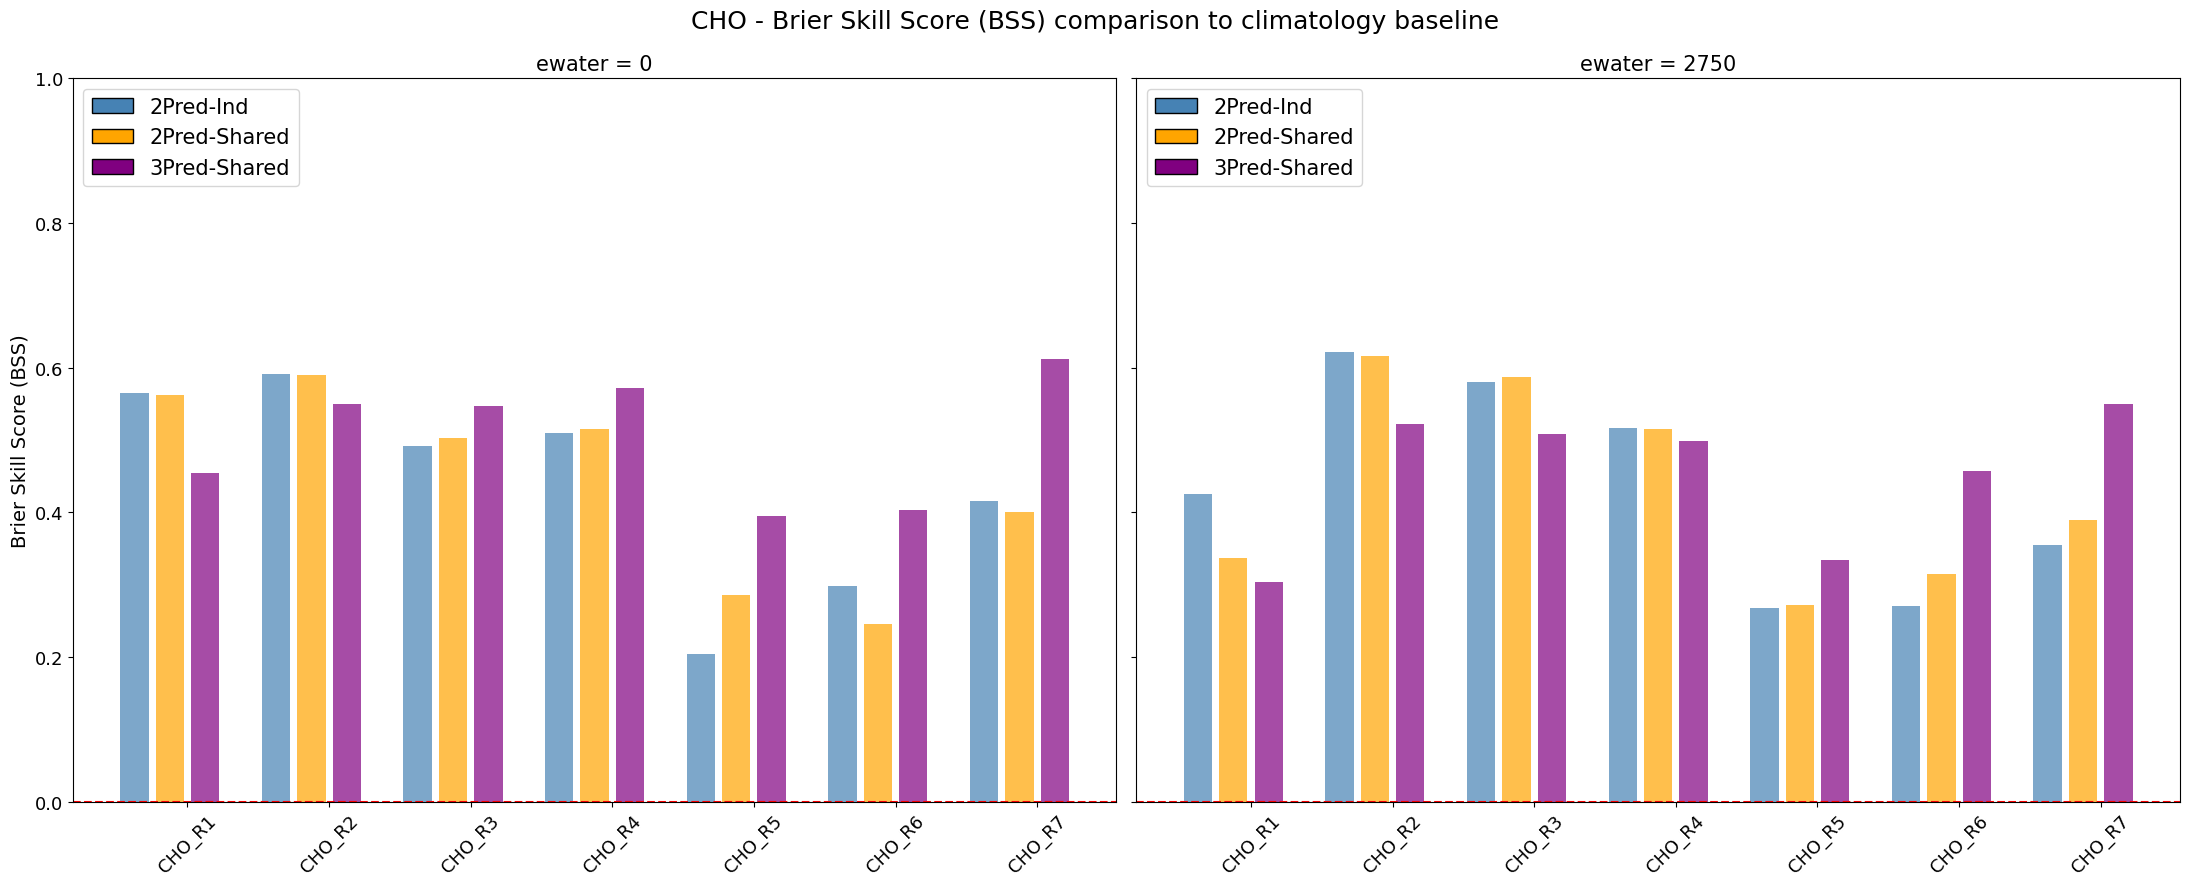

In [11]:
# Choose baseline method: 'climatology', 'random_chance', or 'majority'
baseline = 'climatology'

# Assuming `indicators` and `ewater_values` are defined
indicators = get_indicators(location)

# Storing results separately for each model
bss_all_scenarios = {0: {}, 2750: {}}  # ewater levels

for threshold_i in range(0, 7):
    indicator = indicators[threshold_i]
    
    for ewater in ewater_values:
        for model_name in model_types:
            dset_name = f"{location}-{model_name}"  
            
            y = obs[dset_name][ewater_values.index(ewater), threshold_i].values
            p_samples = predictions[dset_name][ewater_values.index(ewater), threshold_i].values.T
            
            # Compute probability of event occurrence
            P_1 = np.mean(y)  
            P_0 = 1 - P_1  
            
            # Compute baseline Brier score
            if baseline == 'climatology':  
                brier_baseline = P_1 * (1 - P_1)
            elif baseline == 'random_chance':  
                brier_baseline = 0.25
            elif baseline == 'majority':  
                majority_class = 1 if P_1 > P_0 else 0
                brier_baseline = np.mean((majority_class - y) ** 2)  
            else:
                raise ValueError("Invalid baseline. Choose 'climatology', 'random_chance', or 'majority'.")
            
            # Compute Brier scores
            brier_scores = np.mean((p_samples - y) ** 2, axis=1)
            
            assert brier_baseline != 0  # Avoid division by zero
            bss_mean = 1 - (np.mean(brier_scores) / brier_baseline)
            bss_all_scenarios[ewater][(indicator, model_name)] = bss_mean

# Create bar charts
fig, axes = plt.subplots(1, 2, figsize=(22, 9), sharey=True)
colors = {"combined_ind_intercept_inflow_ewater": "steelblue", "combined_interaction": "darkgreen",
          "combined_ind_intercept": "orange", "combined_ind_intercept_lagged": "purple"}

for idx, ewater in enumerate(ewater_values):
    ax = axes[idx]
    positions = []
    bss_means = []
    xticks = []
    labels = []
    
    for i, indicator in enumerate(indicators):
        for j, model_name in enumerate(model_types):
            key = (indicator, model_name)
            if key in bss_all_scenarios[ewater]:
                bss_means.append(bss_all_scenarios[ewater][key])
                positions.append(i * (len(model_types) + 1) + j)
                labels.append(model_name)
        xticks.append(i * (len(model_types) + 1) + (len(model_types) / 2))
    
    ax.bar(positions, bss_means, color=[colors[model_name] for model_name in labels], alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, label="BSS = 0 (baseline)")
    ax.set_xticks(xticks)
    ax.set_xticklabels(indicators, rotation=45, fontsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_title(f"ewater = {ewater}", fontsize=15)
    ax.set_ylim(0.0, 1.0)
    sel_colors = [colors[model_name] for model_name in model_types]
    ax.legend([plt.Rectangle((0, 0), 1, 1, fc=color, edgecolor='black') for color in sel_colors],
              model_names_for_plotting, loc="upper left", fontsize=15)

axes[0].set_ylabel(f"Brier Skill Score (BSS)", fontsize=14)
fig.suptitle(f"{location} - Brier Skill Score (BSS) comparison to {baseline} baseline", fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.99])

plt.savefig(os.path.join(fig_dir,f'bss_barplots_{location}.png'), dpi=300)
plt.show()


<h3>Set model</h3>
Time series, reliability and ROC are per location and model

In [12]:
location = "CHO"
model_name = "combined_ind_intercept_lagged"

<h3>Time series boxplots</h3>

(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)
(16000, 113)
(113,)


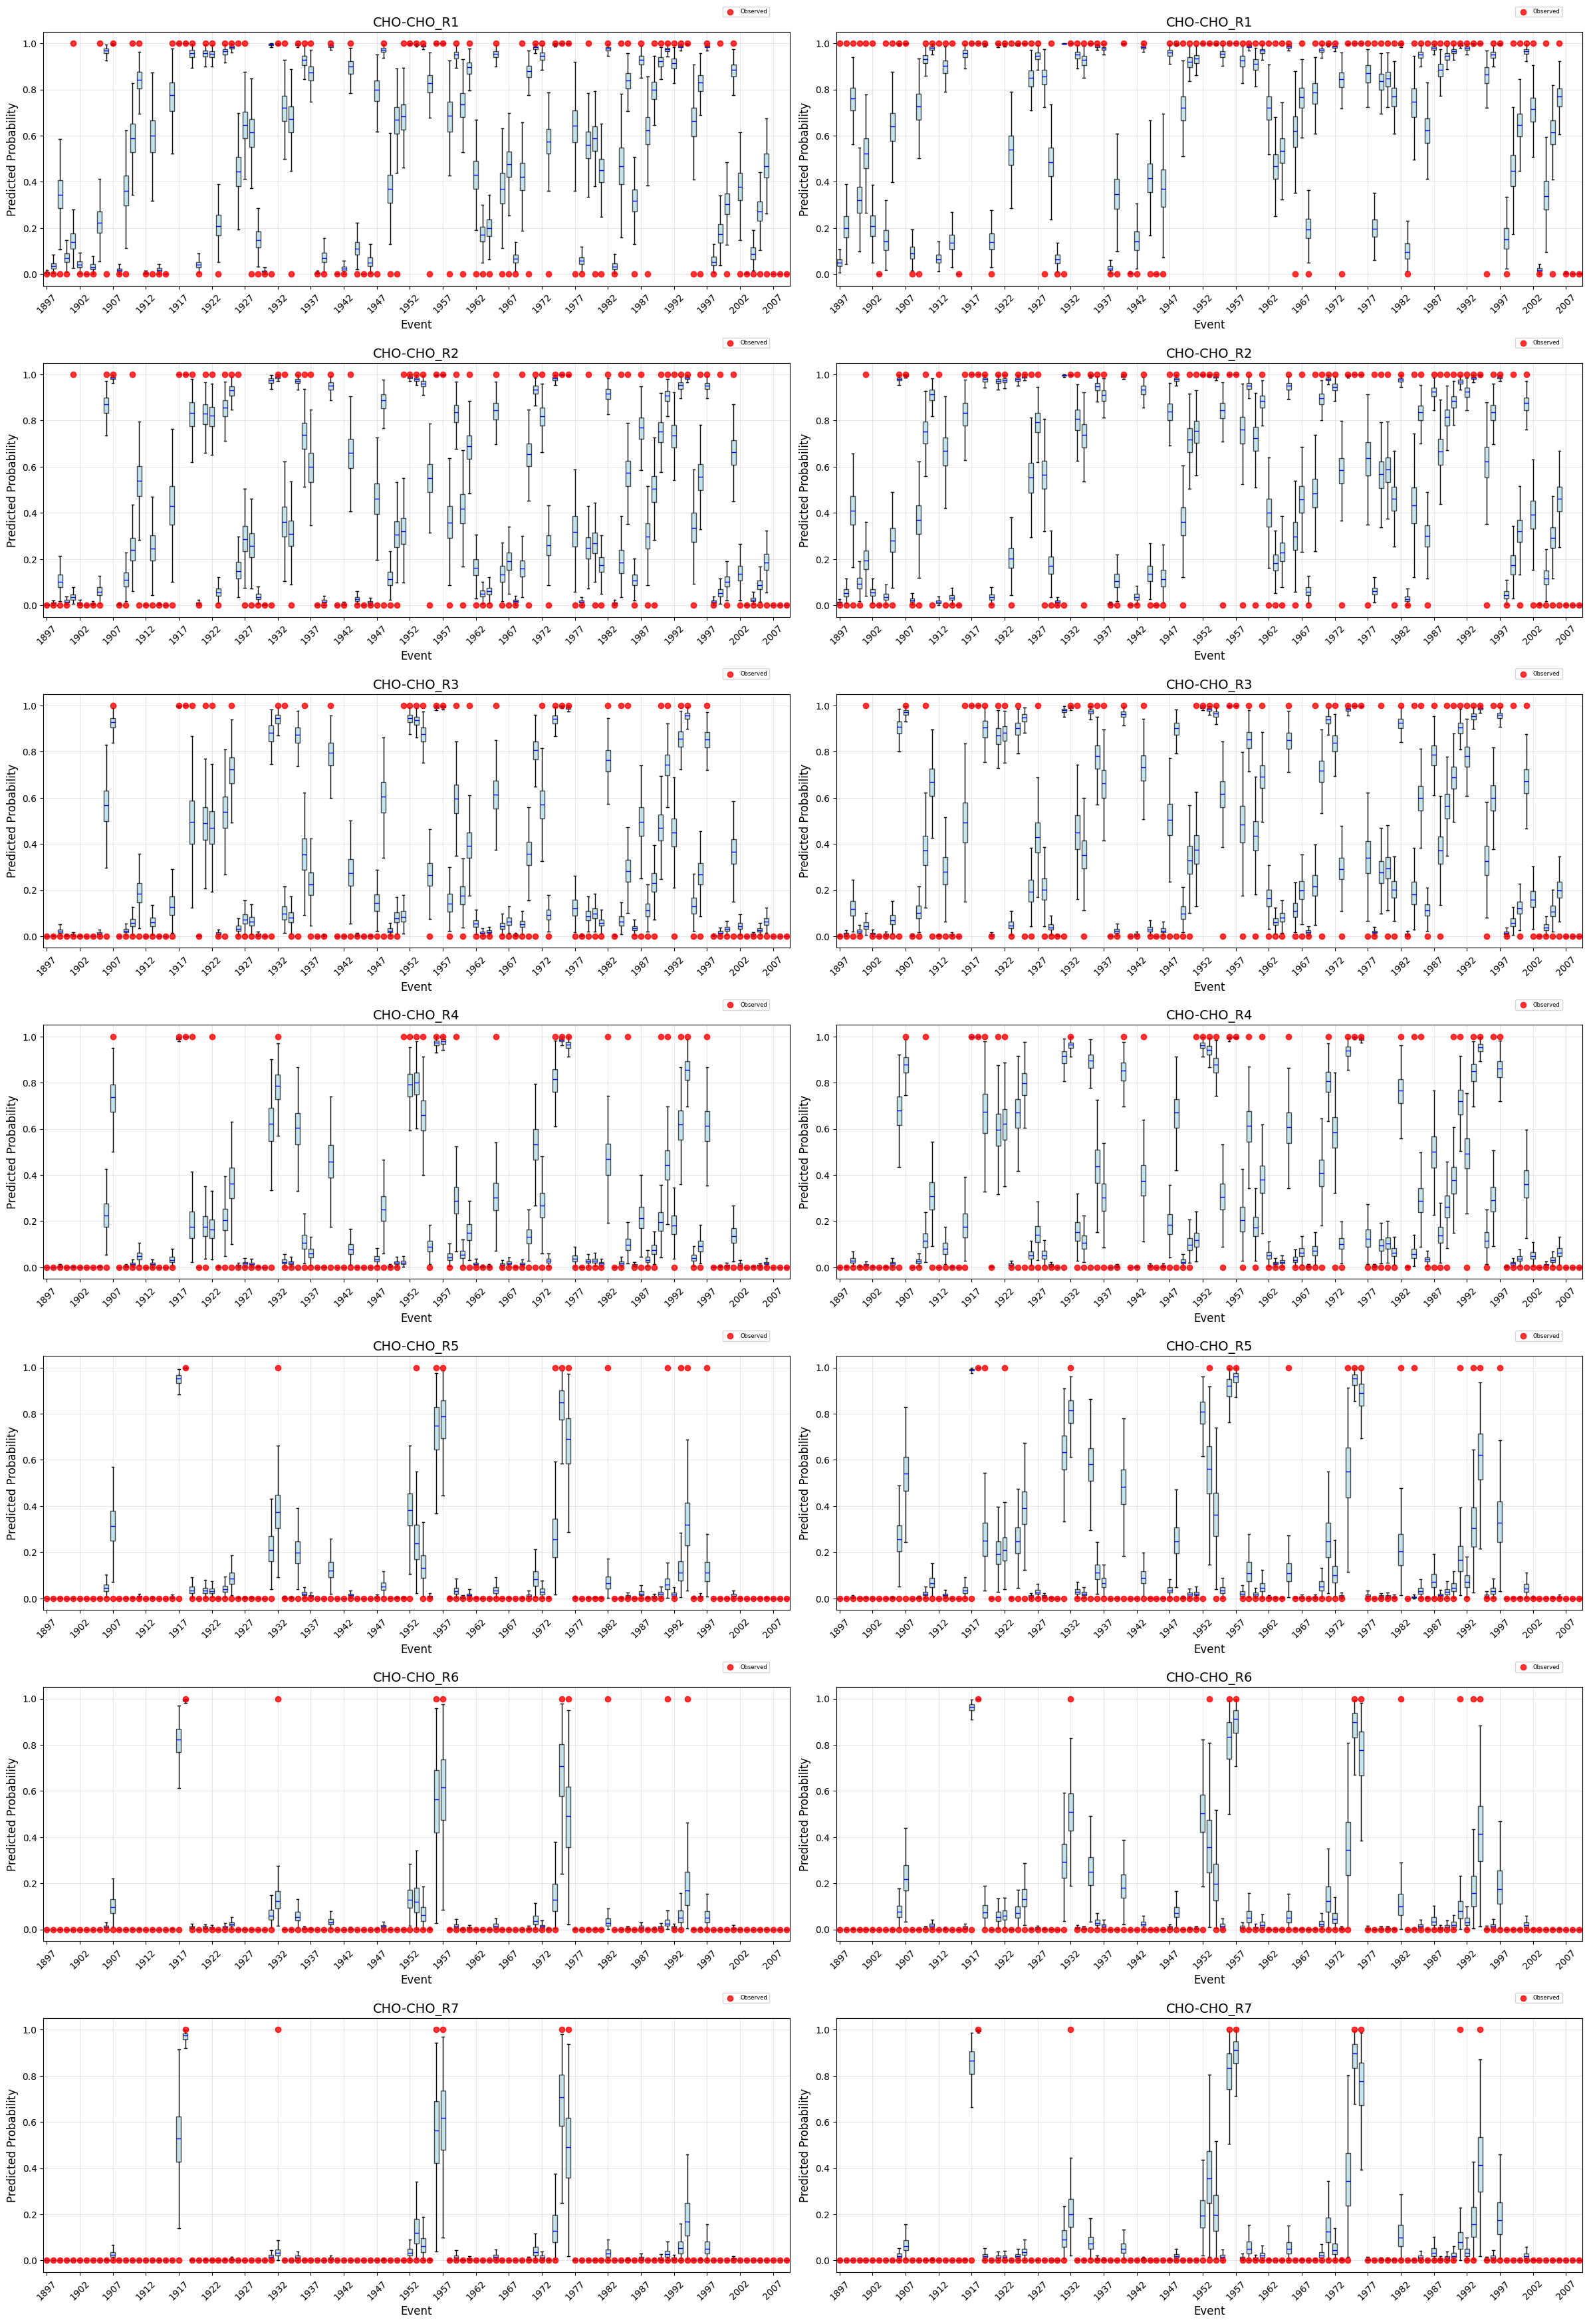

In [13]:

# Assuming you have a list of scenarios
indicators = get_indicators(location)

# Adjust the figure size to accommodate multiple rows
plt.figure(figsize=(24, 35))
plot_i = 1

for threshold_i in range(0,7):

    indicator = indicators[threshold_i]

    for ewater_i, ewater in enumerate(ewater_values):

        dset_name = f"{location}-{model_name}"  
            
        y = obs[dset_name][ewater_values.index(ewater), threshold_i].values
        p_samples = predictions[dset_name][ewater_values.index(ewater), threshold_i].values.T
        
        positions = np.arange(1897, 2010)

        # Create a subplot for each scenario
        ax = plt.subplot(7, 2, plot_i)

        print(p_samples.shape)
        print(positions.shape)

        
    
        # Boxplot for posterior predictive samples
        ax.boxplot(
            p_samples,
            positions=positions,
            widths=0.7,
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", alpha=0.7),
            medianprops=dict(color="blue"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            showfliers=False,  # Suppress outliers for cleaner visualization
        )
    
        # Overlay the actual observations as scatter points
        ax.scatter(
            positions,
            y,
            color="red",
            label="Observed",
            zorder=3,
            alpha=0.8,
        )
    
        # Formatting each subplot
        ax.set_xlabel("Event", fontsize=12)
        ax.set_ylabel("Predicted Probability", fontsize=12)
        ax.set_title(f"{location}-{indicator}", fontsize=14)
        ax.set_xticks(positions[::5])  # Show every 5th tick for clarity
        ax.set_xticklabels([str(int(e)) for e in positions[::5]], rotation=45, fontsize=10)
        ax.grid(alpha=0.3)
    
        # Add the legend outside the plot box
        ax.legend(
            loc="upper left",
            bbox_to_anchor=(0.91, 1.1),  # Top-right corner outside the plot box
            fontsize=6,
            borderaxespad=0,
        )

        plot_i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, f'tseries_boxplots_{model_name}_{location}.png'), dpi=300.)

# Show the plot
plt.show()


<h3>4. Reliability diagram</h3>

(226,) (16000, 226)
(226,) (16000, 226)
(226,) (16000, 226)
(226,) (16000, 226)


c:\src\github_dr\WERP_SFI_Prediction\.venv\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\src\github_dr\WERP_SFI_Prediction\.venv\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(226,) (16000, 226)
(226,) (16000, 226)
(226,) (16000, 226)


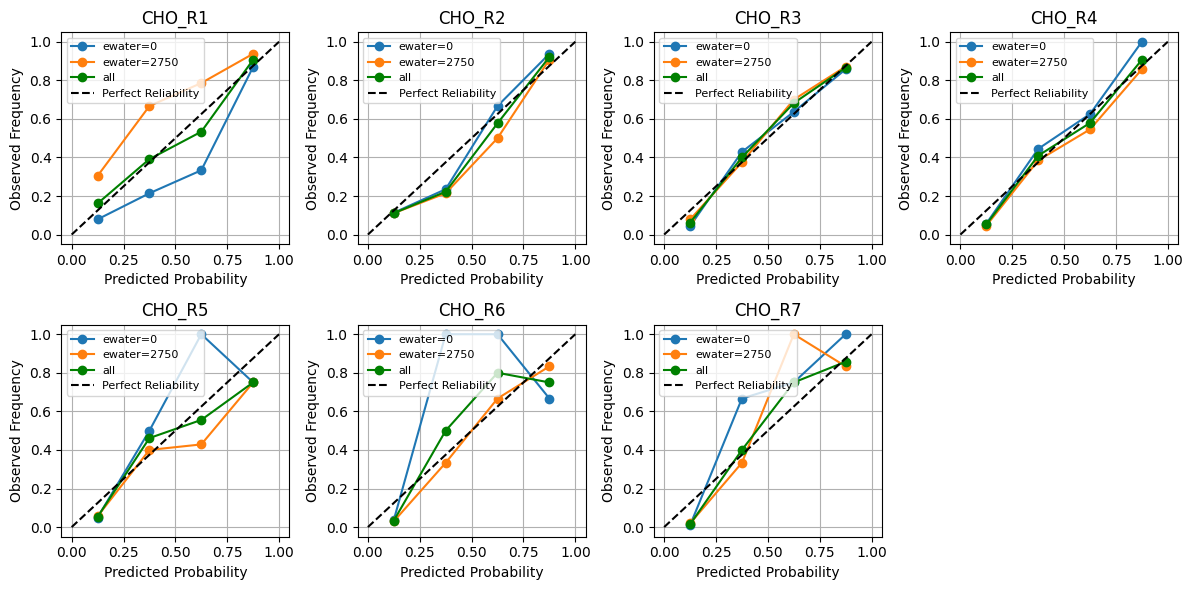

In [14]:

def reliability_diagram_with_forecast_histogram(p_samples, y, n_bins=10, quantiles=(0.05, 0.95), min_samples=0):
    M, N = p_samples.shape
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    forecast_means = np.mean(p_samples, axis=0)
    observed_frequencies = np.full((M, n_bins), np.nan)  # Initialize with NaNs
    forecast_hist = np.zeros(n_bins)
    sample_counts = np.zeros(n_bins)  # Track sample counts per bin

    for m in range(M):
        p = p_samples[m]
        for b in range(n_bins):
            bin_mask = (p >= bin_edges[b]) & (p < bin_edges[b + 1])
            bin_count = np.sum(bin_mask)
            if bin_count >= min_samples:  # Only consider bins with enough samples
                observed_frequencies[m, b] = np.mean(y[bin_mask])
            sample_counts[b] += bin_count

    for b in range(n_bins):
        bin_mask = (forecast_means >= bin_edges[b]) & (forecast_means < bin_edges[b + 1])
        forecast_hist[b] = np.sum(bin_mask)

    # Compute statistics only for bins meeting the threshold
    valid_bins = sample_counts >= min_samples
    bin_centers = bin_centers[valid_bins]
    median_observed = np.nanmedian(observed_frequencies[:, valid_bins], axis=0)
    lower_bound = np.nanquantile(observed_frequencies[:, valid_bins], quantiles[0], axis=0)
    upper_bound = np.nanquantile(observed_frequencies[:, valid_bins], quantiles[1], axis=0)
    forecast_hist = forecast_hist[valid_bins]

    return bin_centers, median_observed, lower_bound, upper_bound, forecast_hist

# Define ewater and indicators
ewater_values = [0, 2750]
indicators = get_indicators(location)  # ['BMF_R1', ..., 'BMF_R7']
nbins = 4

# Setup 4 rows x 4 columns (16 panels)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

plot_idx = 0

for j, indicator in enumerate(indicators):
    ax = axes[plot_idx]
    colors = ["tab:blue", "tab:orange"]
    
    for e_idx, ewater in enumerate(ewater_values):
        dset_name = f"{location}-{model_name}"
        y = obs[dset_name][e_idx, j].values
        p_samples = predictions[dset_name][e_idx, j].values.T
        
        if p_samples.size == 0 or y.size == 0:
            continue
        
        bin_centers, median_observed, lower_bound, upper_bound, forecast_hist = reliability_diagram_with_forecast_histogram(
            p_samples, y, n_bins=nbins, quantiles=(0.1, 0.9)
        )
        
        ax.plot(bin_centers, median_observed, marker="o", label=f"ewater={ewater}", color=colors[e_idx])
        #ax.fill_between(bin_centers, lower_bound, upper_bound, alpha=0.3, color=colors[e_idx])

    y = obs[dset_name][:, j].values
    p_samples = predictions[dset_name][:, j].values

    y = np.concatenate(y, axis=0)  # Shape (116,)
    p_samples = np.concatenate(p_samples, axis=0).T
    print(y.shape, p_samples.shape)
        
    if p_samples.size == 0 or y.size == 0:
        continue
        
    bin_centers, median_observed, lower_bound, upper_bound, forecast_hist = reliability_diagram_with_forecast_histogram(
            p_samples, y, n_bins=nbins, quantiles=(0.1, 0.9)
    )
        
    ax.plot(bin_centers, median_observed, marker="o", label=f"all", color="green")
    #ax.fill_between(bin_centers, lower_bound, upper_bound, alpha=0.3, color="green")
    
    ax.plot([0, 1], [0, 1], "k--", label="Perfect Reliability")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Observed Frequency")
    ax.set_title(f"{indicator}")
    ax.legend(loc=2, fontsize=8)
    ax.grid(True)

    plot_idx += 1

# Hide unused panels
for k in range(plot_idx, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(fig_dir,f'reldiag_{model_name}_{location}.png'), dpi=300.)
plt.show()


<h3>5. ROC plots</h3>

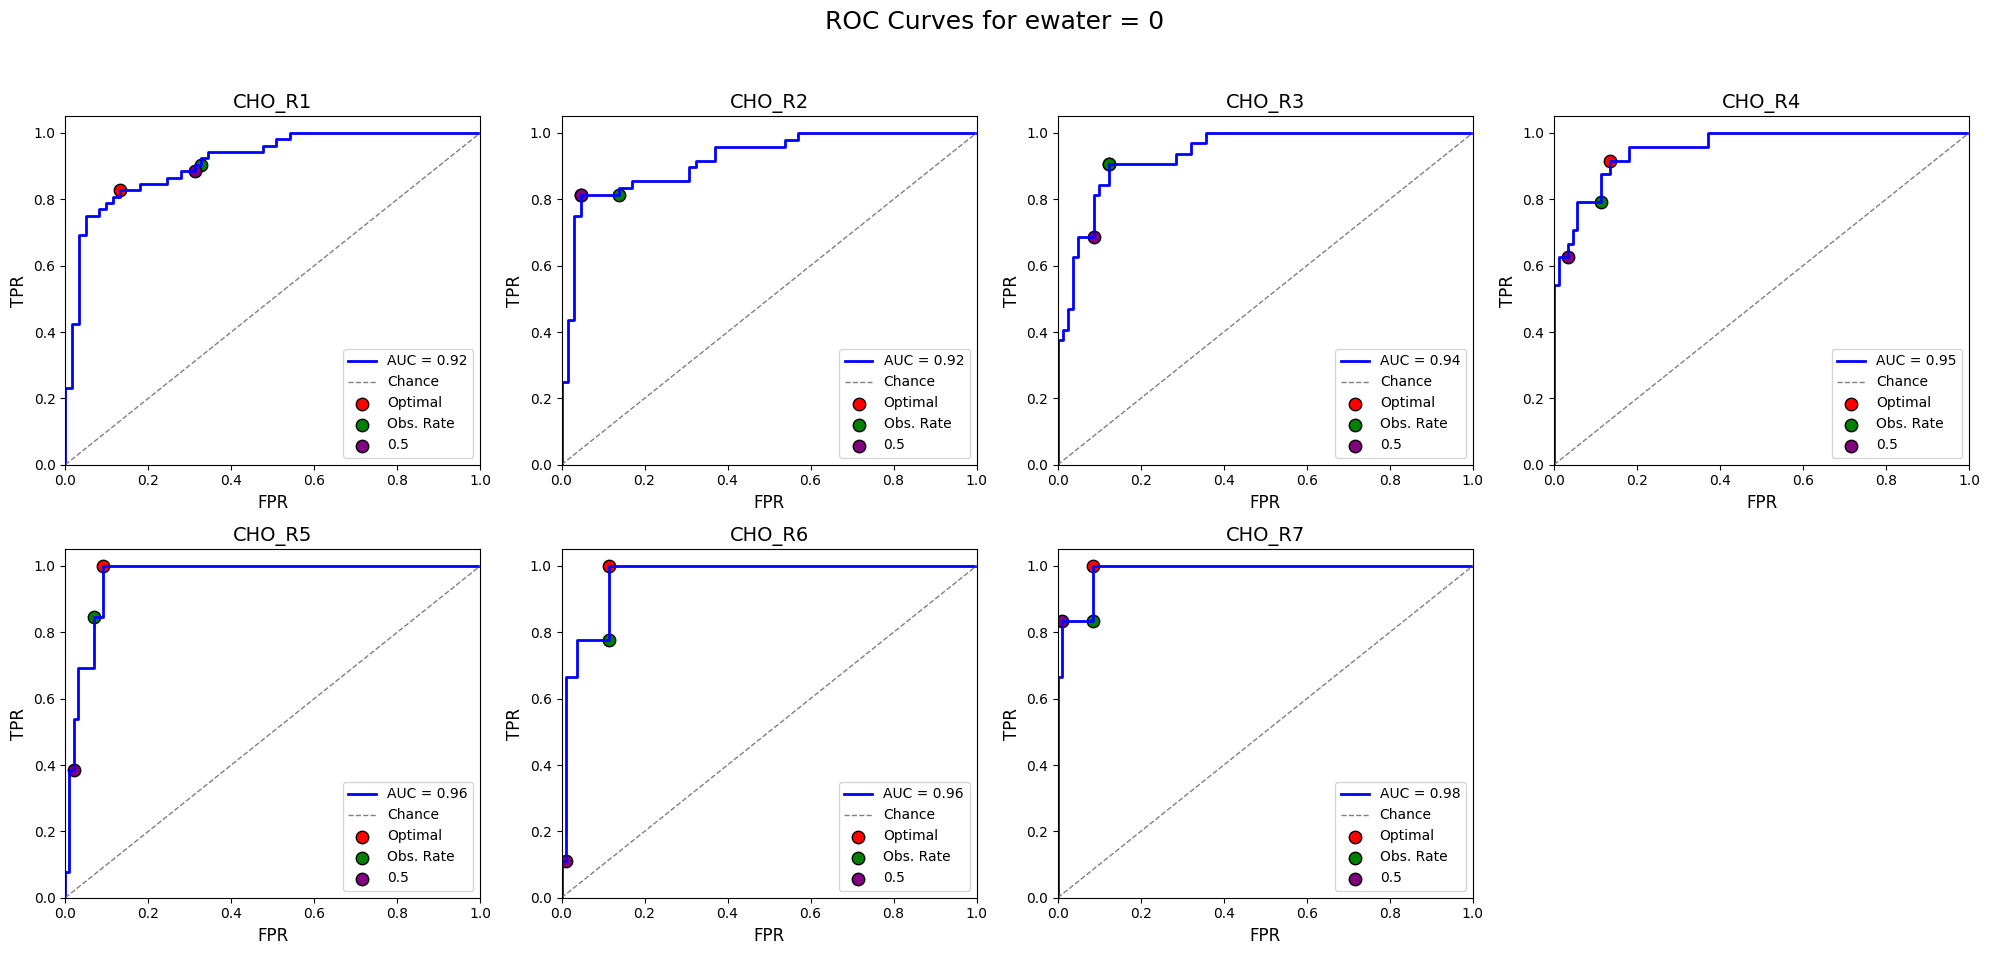

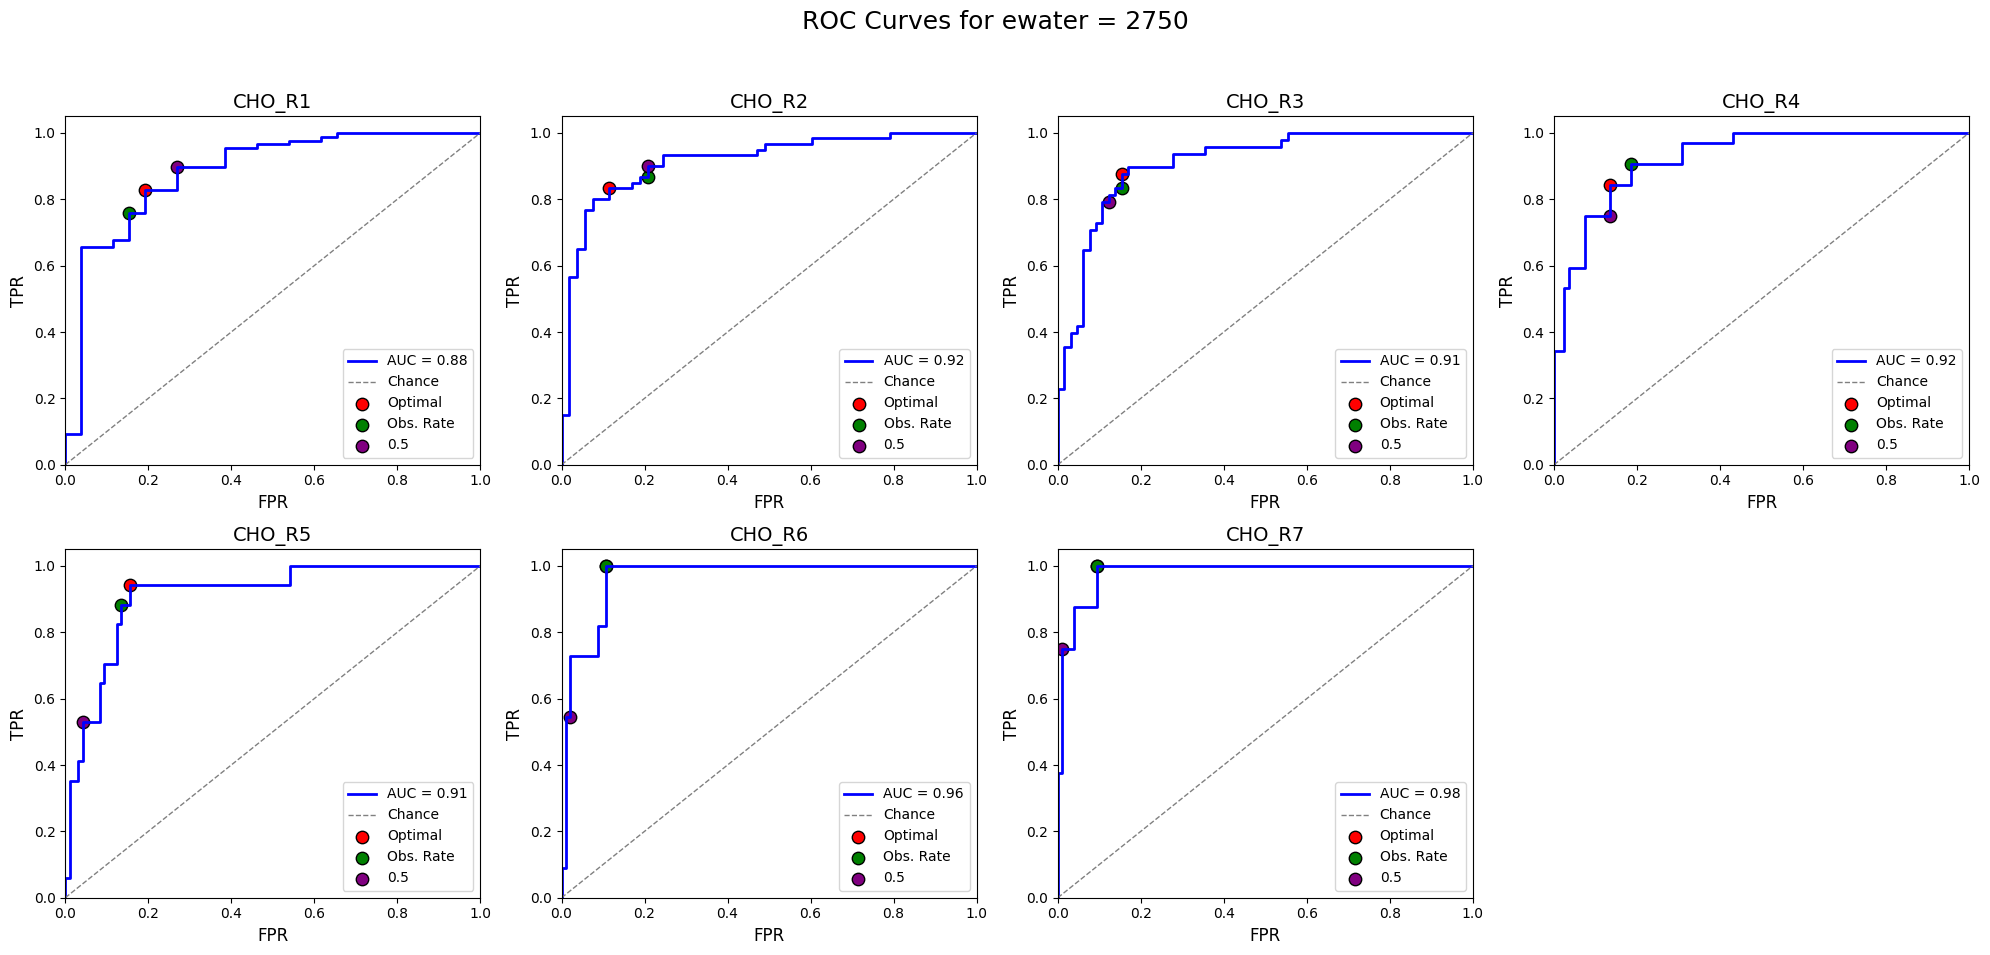

In [15]:


indicators = get_indicators(location)
ewater_values = [0, 2750]

for ewater_i, ewater in enumerate(ewater_values):

    # Create subplots: one panel for each indicator
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for threshold_i, indicator in enumerate(indicators):
        
        ax = axes[threshold_i]

        dset_name = f"{location}-{model_name}"              
        y = obs[dset_name][ewater_values.index(ewater), threshold_i].values
        p_samples = predictions[dset_name][ewater_values.index(ewater), threshold_i].values.T
        
        if p_samples.size == 0 or y.size == 0:
            ax.set_axis_off()
            continue

        p_mean = np.mean(p_samples, axis=0)
        fpr, tpr, thresholds = roc_curve(y, p_mean)
        roc_auc = auc(fpr, tpr)

        optimal_idx = np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))
        observed_rate = np.mean(y)
        closest_idx = np.argmin(np.abs(thresholds - observed_rate))
        half_idx = np.argmin(np.abs(thresholds - 0.5))

        ax.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')

        ax.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=80, edgecolors='black', label=f'Optimal')
        ax.scatter(fpr[closest_idx], tpr[closest_idx], color='green', s=80, edgecolors='black', label=f'Obs. Rate')
        ax.scatter(fpr[half_idx], tpr[half_idx], color='purple', s=80, edgecolors='black', label=f'0.5')

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_title(f"{indicator}", fontsize=14)
        ax.set_xlabel('FPR', fontsize=12)
        ax.set_ylabel('TPR', fontsize=12)
        ax.legend(loc="lower right", fontsize=10)

    # Hide unused axes
    for j in range(len(indicators), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"ROC Curves for ewater = {ewater}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.savefig(os.path.join(fig_dir,f'roc_{model_name}_{location}-{ewater}.png'), dpi=300.)
    plt.show()


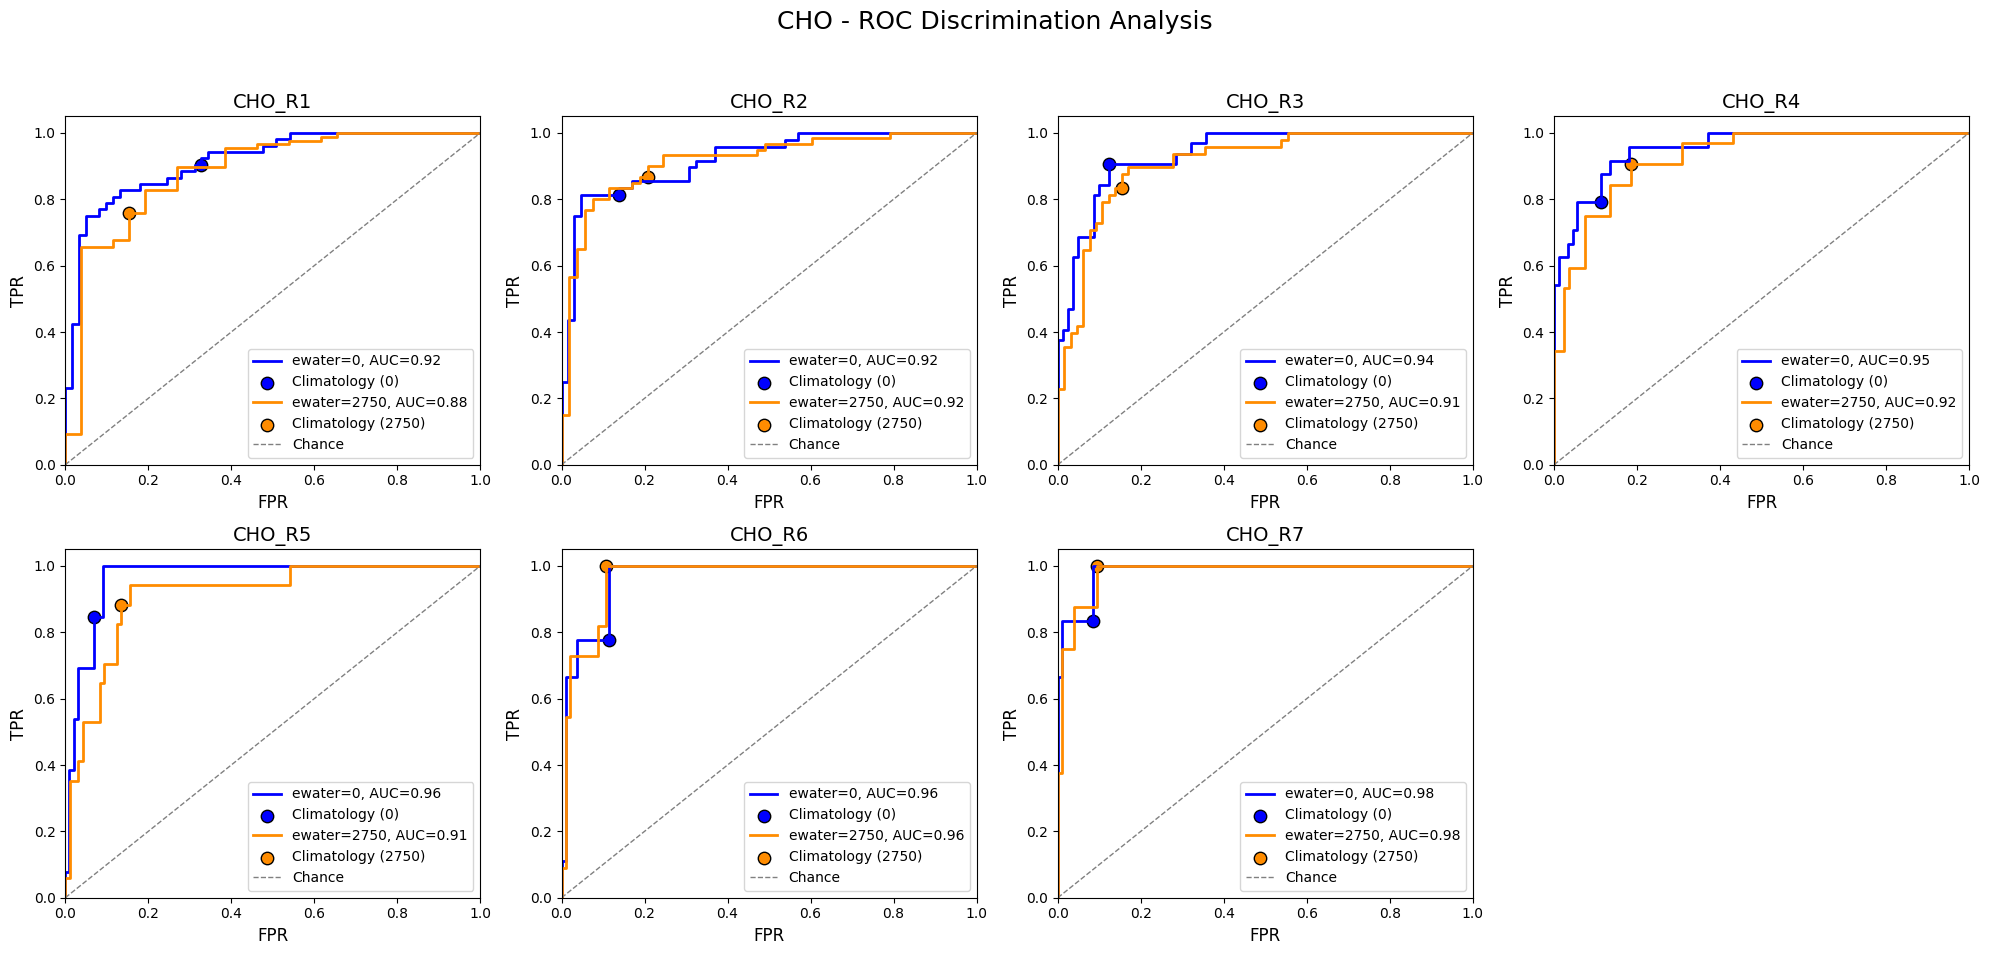

In [16]:

indicators = get_indicators(location)
ewater_values = [0, 2750]
colors = {0: 'blue', 2750: 'darkorange'}

# Create subplots: one panel for each indicator
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for threshold_i, indicator in enumerate(indicators):
    ax = axes[threshold_i]
    
    for ewater in ewater_values:
        dset_name = f"{location}-{model_name}"
        y = obs[dset_name][ewater_values.index(ewater), threshold_i].values
        p_samples = predictions[dset_name][ewater_values.index(ewater), threshold_i].values.T
        
        if p_samples.size == 0 or y.size == 0:
            ax.set_axis_off()
            continue
        
        p_mean = np.mean(p_samples, axis=0)
        fpr, tpr, thresholds = roc_curve(y, p_mean)
        roc_auc = auc(fpr, tpr)
        
        # Find climatological event rate
        observed_rate = np.mean(y)
        closest_idx = np.argmin(np.abs(thresholds - observed_rate))
        
        # Plot ROC curve
        ax.plot(fpr, tpr, color=colors[ewater], lw=2, label=f'ewater={ewater}, AUC={roc_auc:.2f}')
        ax.scatter(fpr[closest_idx], tpr[closest_idx], color=colors[ewater], s=80, edgecolors='black', label=f'Climatology ({ewater})')
        
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(f"{indicator}", fontsize=14)
    ax.set_xlabel('FPR', fontsize=12)
    ax.set_ylabel('TPR', fontsize=12)
    ax.legend(loc="lower right", fontsize=10)

# Hide unused axes
for j in range(len(indicators), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle(f"{location} - ROC Discrimination Analysis", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(fig_dir,f'roc_{model_name}_{location}_combined.png'), dpi=300.)
plt.show()
